In [280]:
from collections import defaultdict, Counter
import networkx as nx
import numpy as np
import pylab as plt
import matplotlib as mpl
import random
import torch
import torch.nn as nn
from copy import deepcopy
from torch import optim
from scipy import stats
import torch.nn.functional as F
from torch.autograd import Variable
from scipy.interpolate import UnivariateSpline
#for word2vec:
#https://towardsdatascience.com/implementing-word2vec-in-pytorch-skip-gram-model-e6bae040d2fb
#for transD:
#https://github.com/jimmywangheng/knowledge_representation_pytorch/
#for RNN:
# https://iamtrask.github.io/2015/11/15/anyone-can-code-lstm/

def oneHot(entity_idx,entity_size):
    x = torch.zeros(entity_size).float()
    x[entity_idx] = 1.0
    return x

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return phi,rho

# word2vec 

In [908]:
class word2vec(nn.Module):

    def __init__(self, entity_size, embedding_size):
        super(word2vec, self).__init__()
        
        self.W_in = nn.Linear(entity_size, embedding_size)
        self.W_out =  nn.Linear(embedding_size,entity_size)
        self.W_out.weight.data = self.W_in.weight.data.transpose(0,1)
    
    def forward(self, oneHot):
        return self.W_out(self.W_in(oneHot))

In [260]:
entity_size=10
embedding_size=2
wv=word2vec(entity_size, embedding_size)
pairs=list(zip(range(9),range(1,10)))+[(9,0)]+list(zip(range(10),range(10)))+[(0,9)]+list(zip(range(1,10),range(9)))

# training
num_epochs = 2000
learning_rate = 0.002
optimizer = optim.Adam(wv.parameters(), lr=learning_rate)
POS={}
Loss=[]
for epo in range(num_epochs):
    total_loss = 0
    
    for i, j in pairs:
        optimizer.zero_grad()
        onehot=oneHot(i,entity_size)
        predict=wv.forward(onehot)
        log_softmax_predict = F.log_softmax(predict, dim=0)
        target = Variable(torch.LongTensor([j]))
        loss = F.nll_loss(log_softmax_predict.view(1,-1),target)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    POS[epo]=np.copy(wv.W_in.weight.data.numpy().T)
    if epo % 400 == 0:    
        print(f'Loss at epo {epo}: {total_loss/len(data)}')# print average loss within an epoch
    Loss.append(total_loss/len(data))

Loss at epo 0: 7.070470416545868
Loss at epo 400: 3.7219464063644407
Loss at epo 800: 3.721681833267212
Loss at epo 1200: 3.7216176271438597
Loss at epo 1600: 3.7215922594070436


Text(0,0.5,'Loss')

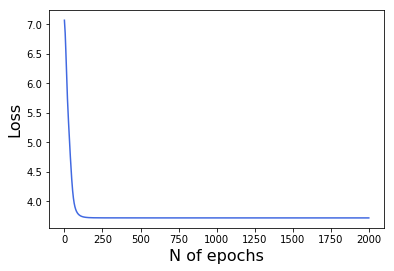

In [261]:
plt.plot(Loss,color='RoyalBlue',marker='')
plt.xlabel('N of epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)

In [144]:
#for i, j in pairs:
#    onehot=oneHot(i,vocabulary_size)
#    z=np.argmax(wv.forward(onehot).data.numpy())
#    print("input=%s, target=%s, predict = %s"% (i,j,z))

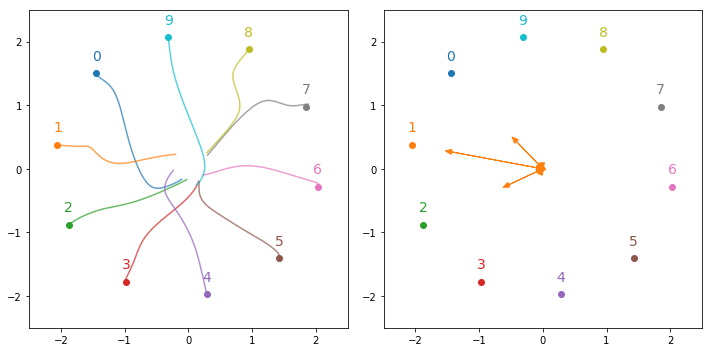

In [277]:
# visualization
# prepare data
fig = plt.figure(figsize=(10, 5),facecolor='white')
cs=dict(zip(range(10),mpl.rcParams['axes.prop_cycle']))
pos=dict(zip(range(10),wv.W_in.weight.data.numpy().T))
PS=defaultdict(lambda:[])
for epo in range(num_epochs):
    p=POS[epo]
    for n in range(10):
        PS[n].append(p[n])
# calculate predict probability for particular input 
target = 1
predict_probability=np.exp(F.log_softmax(wv.forward(oneHot(target,entity_size)),dim=0).data.numpy())
pp=dict(zip(range(10),predict_probability))
#
ax = fig.add_subplot(121)
x,y=pos[0]
r=np.sqrt(x**2+y**2)
delta=r/5
for i in pos:
    x,y=pos[i]
    plt.plot(x,y,marker='o',color=cs[i]['color'])
    plt.text(x,y+delta/2,i,ha='center',size=14,color=cs[i]['color'])
plt.xlim(-r-delta,r+delta)
plt.ylim(-r-delta,r+delta)

for i in range(10):
    x,y=np.array(PS[i]).T
    plt.plot(x,y,cs[i]['color'],linestyle='-',alpha=0.7)
#
ax = fig.add_subplot(122)
x,y=pos[0]
r=np.sqrt(x**2+y**2)
delta=r/5
for i in pos:
    x,y=pos[i]
    plt.plot(x,y,marker='o',color=cs[i]['color'])
    s=1.5*pp[i]
    plt.arrow(0,0,x*s,y*s,head_width=0.08, head_length=0.1,length_includes_head=True,color=cs[target]['color'])
    plt.text(x,y+delta/2,i,ha='center',size=14,color=cs[i]['color'])
plt.xlim(-r-delta,r+delta)
plt.ylim(-r-delta,r+delta)

#
plt.tight_layout()
plt.show()

# TransE

In [457]:
class transE(nn.Module):

    def __init__(self, entity_size, relation_size, embedding_size):
        super(transE, self).__init__()

        self.W_in = nn.Linear(entity_size, embedding_size,bias='false')
        self.W_re = nn.Linear(relation_size, embedding_size,bias='false')

    def forward(self, head, relation, tail): 
        error = self.W_in(head) + self.W_re(relation) - self.W_in(tail)
        return torch.sum(error ** 2)


In [459]:
entity_size=10
embedding_size=2
relation_size=1
triplets=list(zip(range(9),[0]*10,range(1,10)))
transe = transE(entity_size, relation_size, embedding_size)

# training
num_epochs = 100
learning_rate = 0.01
optimizer = optim.Adam(transe.parameters(), lr=learning_rate)
POS={}
RE={}
Loss=[]
for epo in range(num_epochs):
    total_loss = 0
    for i, j, k in triplets:
        optimizer.zero_grad()
        
        head = oneHot(i,entity_size)
        relation = oneHot(j,relation_size)
        tail = oneHot(k,entity_size)
        
        loss = transe.forward(head, relation, tail)
    
        total_loss += loss.item()
        #transe.W_in.weight.data[0][0]=0# fix the position of "9"
        #transe.W_in.weight.data[1][0]=0#
        loss.backward()
        optimizer.step()
    POS[epo]=np.copy(transe.W_in.weight.data.numpy().T)
    RE[epo]=np.copy(transe.W_re.weight.data.numpy().T[0])
    if epo % 20 == 0:    
        print(f'Loss at epo {epo}: {total_loss/len(data)}')# print average loss within an epoch
    Loss.append(total_loss/len(data))

Loss at epo 0: 1.0873793423175813
Loss at epo 20: 0.003403442201670259
Loss at epo 40: 0.0004588571644490003
Loss at epo 60: 3.716180904689281e-05
Loss at epo 80: 1.600851967964445e-06


Text(0,0.5,'Loss')

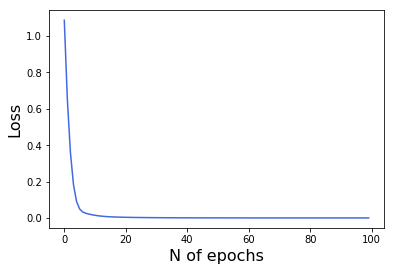

In [460]:
plt.plot(Loss,color='RoyalBlue',marker='')
plt.xlabel('N of epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)

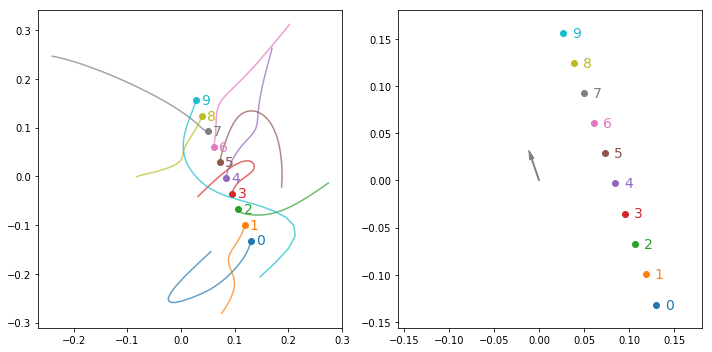

In [495]:
# visualization
# prepare data
fig = plt.figure(figsize=(10, 5),facecolor='white')
cs=dict(zip(range(10),mpl.rcParams['axes.prop_cycle']))
pos=dict(zip(range(10),transe.W_in.weight.data.numpy().T))
PS=defaultdict(lambda:[])
for epo in range(num_epochs):
    p=POS[epo]
    for n in range(10):
        PS[n].append(p[n])
    
#
ax = fig.add_subplot(121)
x,y=pos[0]
r=np.sqrt(x**2+y**2)

for i in pos:
    x,y=pos[i]
    plt.plot(x,y,marker='o',color=cs[i]['color'])
    plt.text(x+delta,y,i,va='center',size=14,color=cs[i]['color'])
for i in range(10):
    x,y=np.array(PS[i]).T
    plt.plot(x,y,cs[i]['color'],linestyle='-',alpha=0.7)
        
#
ax = fig.add_subplot(122)
delta=0.01
for i in pos:
    x,y=pos[i]
    plt.plot(x,y,marker='o',color=cs[i]['color'])
    plt.text(x+delta,y,i,va='center',size=14,color=cs[i]['color'])

#for i in range(10):
#    x,y=np.array(PS[i]).T
#    plt.plot(x,y,cs[i]['color'],linestyle='-',alpha=0.7)
    
xr,yr=transe.W_re(oneHot(0,relation_size)).data.numpy()

y1,y2=ax.get_ylim()
ax.set_ylim(y1-delta,y2+delta)
x1,x2=ax.get_ylim()
ax.set_xlim(min(xr,x1),max(xr,x2))
plt.arrow(0,0,xr,yr,head_width=0.005, head_length=0.01, fc='gray', ec='gray',length_includes_head='True')

#xe,ye=np.array(list(RE.values())).T
#plt.plot(xe,ye,'k-')
#
plt.tight_layout()
plt.show()

# RNN

In [926]:
class RNN(nn.Module):

    def __init__(self, entity_size, embedding_size):
        super(RNN, self).__init__()
        
        self.W_in = nn.Linear(entity_size, embedding_size,bias='false')
        self.W_out =  nn.Linear(embedding_size, entity_size,bias='false')
        self.W_out.weight.data = self.W_in.weight.data.transpose(0,1)
        self.W_rotate = nn.Linear(embedding_size, embedding_size,bias='false')
        
    def forward(self, oneHot, legacy):
        legacy_ = self.W_rotate(legacy) + self.W_in(oneHot)
        return legacy_
    
    def predict(self,legacy):
        return self.W_out(legacy)
    
    
    def initLegacy(self):
        return torch.zeros(embedding_size)
    

In [930]:
# data and model
triplets=list(zip(range(8),range(1,9),range(2,10)))+[(8,9,0)]+[(9,0,1)]
entity_size=10
embedding_size=2
rnn=RNN(entity_size, embedding_size)
legacy=rnn.initLegacy()
learning_rate = 0.01
optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)
num_epochs = 100

# trainning
Loss=[]
for epoch in range(num_epochs):
    total_loss=0
    for i,j,k in triplets:
        optimizer.zero_grad() 
        # forward
        for x in (i,j):
            onehot=oneHot(x,entity_size)
            legacy=rnn.forward(onehot,legacy)
        predict=rnn.predict(legacy) 
        log_softmax_predict = F.log_softmax(predict, dim=0)
        target = Variable(torch.LongTensor([k]))
        #loss = F.nll_loss(log_softmax_predict.view(1,-1),target)
        loss = F.cross_entropy(log_softmax_predict.view(1,-1),target)
        total_loss += loss.item()
        # backward
        loss.backward(retain_graph=True)
        optimizer.step()
    Loss.append(total_loss/len(triplets))
    if epoch%10==0:
        print(epoch, total_loss/len(triplets))

0 2.452012372016907
10 2.0978466033935548
20 0.9845185935497284
30 0.5157193332910538
40 0.06761122923344373
50 0.0014049191700905793
60 0.9249423563480377
70 0.59358349442482
80 0.4257454350590706
90 0.3020884618163109


Text(0,0.5,'Loss')

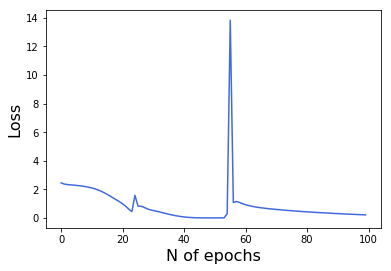

In [931]:
plt.plot(Loss,color='RoyalBlue',marker='')
plt.xlabel('N of epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)

In [932]:
posE=dict(zip(range(10),rnn.W_in.weight.data.numpy().T))
W=rnn.W_rotate.weight.data.numpy().T # self.W_h(legacy) = np.matmul(W_h.T,legacy.data.numpy())

In [933]:

L={}
for i,j,k in triplets: 
    for x in (i,j):
        onehot=oneHot(x,entity_size)
        legacy=rnn.forward(onehot,legacy)
    predict=rnn.predict(legacy) 
    L[k]=legacy.data.numpy()
    print((i,j,k),np.argmax(predict.data.numpy()),legacy.data.numpy())

(0, 1, 2) 2 [ 0.97077477 -5.15767   ]
(1, 2, 3) 3 [ 2.2787313 -2.4329014]
(2, 3, 4) 4 [3.3277078 0.7843952]
(3, 4, 5) 5 [3.2277453 4.912281 ]
(4, 5, 6) 6 [0.807947 7.703997]
(5, 6, 7) 7 [-1.7225765  6.16561  ]
(6, 7, 8) 8 [-2.9965243  2.9749203]
(7, 8, 9) 9 [-3.710538  -0.4679677]
(8, 9, 0) 0 [-3.3279586 -4.107975 ]
(9, 0, 1) 1 [-1.2630078 -6.3397965]


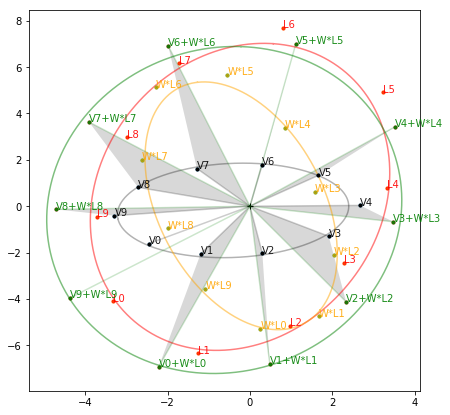

In [1037]:
fig = plt.figure(figsize=(7, 7),facecolor='white')

ax = fig.add_subplot(111)

plt.plot(0,0,'k+')

# embeddings
x,y=np.array([posE[i] for i in range(10)]).T
fit=fitEllipse(x,y)
plt.plot(fit[0, :], fit[1, :], 'k',alpha=0.3)

#legacy
x,y=np.array([L[i] for i in range(10)]).T
fit=fitEllipse(x,y)
plt.plot(fit[0, :], fit[1, :], 'r',alpha=0.5)

#rotate legacy
x,y=np.array([np.matmul(L[i],W) for i in range(10)]).T
fit=fitEllipse(x,y)
plt.plot(fit[0, :], fit[1, :], 'orange',alpha=0.5)

#rotate legacy plus embeding
x,y=np.array([posE[i]+np.matmul(L[i],W) for i in range(10)]).T
fit=fitEllipse(x,y)
plt.plot(fit[0, :], fit[1, :], 'green',alpha=0.5)

for n in range(10):
    
    a,b=L[n]
    plt.text(a,b,'L'+str(n),color='r',alpha=0.9)
    plt.plot(a,b,marker='.',color='r',alpha=0.5)
    #plt.plot(a,b,'r.')
    #plt.plot([0,a],[0,b],'r--',alpha=0.5)
    
    x1,y1=np.matmul(L[n],W)
    plt.plot(x1,y1,marker='.',color='orange',alpha=0.5)
    plt.text(x1,y1,'W*L'+str(n),color='orange',alpha=0.9)
    #plt.plot([a,x1],[b,y1],color='gray',alpha=0.5)
    
    x2,y2=posE[n]+np.matmul(L[n],W)
    plt.plot(x2,y2,'g.',alpha=.8)
    plt.plot([0,x2],[0,y2],'g-',alpha=0.2)
    plt.text(x2,y2,'V'+str(n)+'+W*L'+str(n),color='g',alpha=0.9)

    x,y=posE[n]
    plt.plot(x,y,'k.')
    plt.plot([0,x],[0,y],'k-',alpha=0.2)
    plt.text(x,y,'V'+str(n),color='k',alpha=0.9)

# triangles
    if n<9:
        x_,y_=posE[n+1]
        coord = [[0,0],[x2,y2], [x_,y_], [0,0]]
        xc, yc = zip(*coord)
        plt.fill_between(xc,yc,facecolor='gray',alpha=.3)

In [994]:
a,b=np.linalg.eigvals(W)
a,b

((0.45305339+0.52837867j), (0.45305339-0.52837867j))

In [946]:
np.imag(a)/np.real(a),180*np.arctan(np.imag(a)/np.real(a))/np.pi

(1.1662614, 49.38886907702501)

In [981]:


def fitEllipse(x,y):
    N=len(x)
    plt.plot(x, y, '.')
    xmean, ymean = x.mean(), y.mean()
    x -= xmean
    y -= ymean
    U, S, V = np.linalg.svd(np.stack((x, y)))

    tt = np.linspace(0, 2*np.pi, 1000)
    circle = np.stack((np.cos(tt), np.sin(tt)))    # unit circle
    transform = np.sqrt(2/N) * U.dot(np.diag(S))   # transformation matrix
    fit = transform.dot(circle) + np.array([[xmean], [ymean]])
    return fit


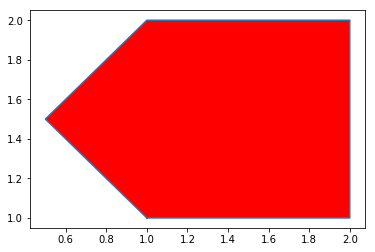

In [1017]:
coord = [[1,1], [2,1], [2,2], [1,2], [0.5,1.5]]
coord.append(coord[0]) #repeat the first point to create a 'closed loop'

xs, ys = zip(*coord) #create lists of x and y values

plt.figure()
plt.plot(xs,ys)
plt.fill(xs,ys,'r')
plt.show() 